### Intro: Searching for objects in images

Detect and track vehicles in a video stream
* Anticipate whether there will be an accident and avoid accidents.
* Assess how far away cars are and where they are going.
* Extract features to reliably classify vehicles
* Search image for detections and track detections frame to frame from a video stream
    * Separate false positives from true positives
* Deep Learning vs CV approaches:
    * CV approaches tune parameters by hand: intuition as to what works and why
    * Deep Learning works better but seems like a black box. 
    * Both approaches: Maximum insight and best performance in algorithms.
    
    
#### Useful features for identifying cars in an image
* Colour, position, shape, apparent size


### Manual Vehicle Detection
* Drawing bounding boxes using `cv2.rectangle()`.
```
cv2.rectangle(image_to_draw_on, (x1, y1), (x2, y2), color, thick)```

    

Coords:  (100, 100) (200, 200)
Coords:  (300, 300) (400, 400)


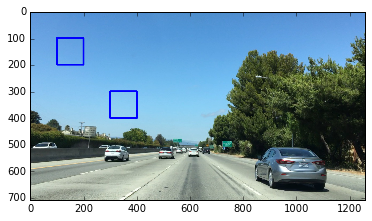

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
image = mpimg.imread('images/21-bbox-example-image.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for i in bboxes:
        print("Coords: ", i[0], i[1])
        cv2.rectangle(draw_img, i[0], i[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]

result = draw_boxes(image, bboxes)
plt.imshow(result)

## Features

Features describe the characteristics of an object, and with images, it really all comes down to intensity and gradients of intensity, and how these features capture the color and shape of an object.

![](images/21-1.png)
![](images/21-2.png)

### Colour Features
Q: Does a part of the image contain a car?

#### Template Matching
Image difference between car image and test region and see if difference is small. I.e. tracking colour values, aggregating them and seeing if the difference is small compared to the threshold.

But not v useful for our case:
    * With template matching we can only find very close matches, and changes in size or orientation of a car make it impossible to match with a template. (See exercise below.)

￼![](images/21-3.png)
￼![](images/21-4.png)

* Search the image using `cv2.matchTemplate()`
    * Can choose between squared difference (locate global min diff) or correlation methods (locate global max)
    * [OpenCV Template Matching Tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html)
* Extract the location of the best match using `cv2.minMaxLoc()`.

```
cv2.matchTemplate()```


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
templist = ['cutout1.jpg', 'cutout2.jpg', 'cutout3.jpg',
            'cutout4.jpg', 'cutout5.jpg', 'cutout6.jpg']

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

Result:
￼![](images/21-5.png)

Bugs: Swapping `tmp.shape[1]` and `tmp.shape[0]`



### Colour Histogram Features
* Robust to variations in size (through normalising histogram), orientation.
* May mark unwanted regions

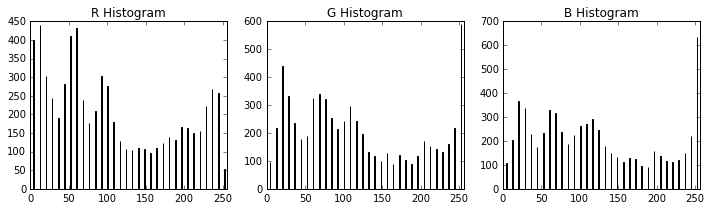

In [6]:
# Construct histogram of R, G, B images
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('images/cutout1.jpg')

# Take histograms in R, G, and B
# Arbitrarily chosen 32 bins and 
# specified range to get orderly bin sizes
rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

# rhist[0] contains the counts in each of the bins and 
# rhist[1] contains the bin edges

# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

In [5]:
hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))

In [ ]:
# As a function

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('cutout1.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

### Colour Spaces

Q: How to represent objects of the same class that come in different colours? (Colour invariance)

Cars seem more saturated than the paler background.

Take images and see how pixels are distributed in different colour spaces, and see if car pixels stand out from non-car pixels in a certain dimension of the colour space.



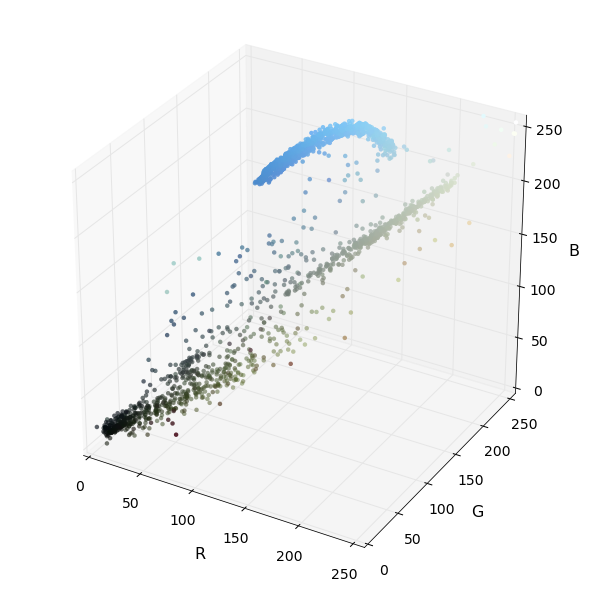

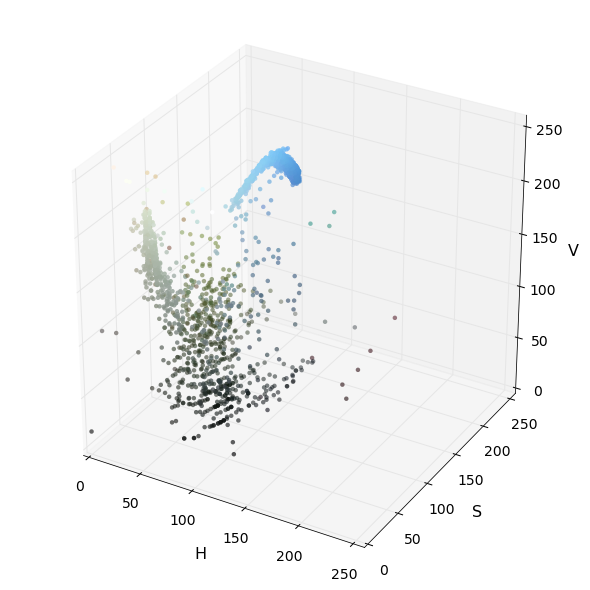

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread("images/21-bbox-example-image.jpg")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.bb  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

### Spatial Binning of Colour

Scale down the resolution of an image using `cv2.resize()`.

In [22]:
import cv2
import matplotlib.image as mpimg

image = mpimg.imread('images/spatial_binning_test_img.jpg')
small_img = cv2.resize(image, (32, 32))
print(small_img.shape)

(32, 32, 3)


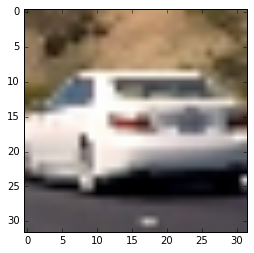

In [23]:
plt.imshow(small_img)

In [24]:
# Convert to one-dimensional feature vector
feature_vec = small_img.ravel()
print(feature_vec.shape)

(3072,)


Write a function that allows you to convert any test image into a feature vector that you can feed your classifier

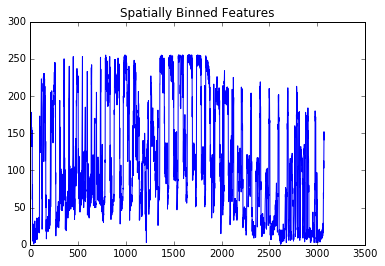

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('images/cutout1.jpg')

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)   
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

### Gradient Features
Gradients

Obtain a signature for the shape (chop image into windows using a grid and align them in a 1D array) to distinguish between shapes. 
![](images/21-9.png)

* Using the gradient values directly makes the signature too sensitive -> using Histogram of Gradients
    * Each pixel votes on the gradients. The weight of that vote depends on the gradient magnitude for that pixel.
    * Resource: [Presentation](https://www.youtube.com/watch?v=7S5qXET179I) on using HOG features for pedestrian detection by Navneet Dalal, the original developer of HOG for object detection.

#### Data Exploration: Car images and not-car images

Your function returned a count of 1196  cars and 1199  non-cars
of size:  (64, 64, 3)  and data type: uint8


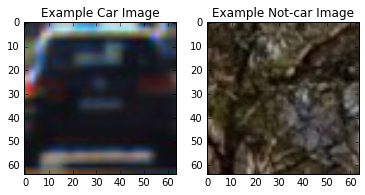

In [43]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

cars = glob.glob('vehicles_smallset/*/*.jpeg')
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')
"""
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


#### scikit-image HOG

* [Documentation](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog)
* [Explanation and Tutorial](http://scikit-image.org/docs/dev/auto_examples/plot_hog.html)

`hog()`
* Input: A single color channel or grayscaled image
* Parameters: 
    * `orientations` (int): 
        * represents the number of orientation bins that the gradient information will be split up into in the histogram. 
        * Typical values are between 6 and 12 bins.
    * `pixels_per_cell`:
        * specifies the cell size over which each gradient histogram is computed. 
        * This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.
    * `cells_per_block`:
        * passed as a 2-tuple
        * specifies the local area over which the histogram counts in a given cell will be normalized. 
        * Block normalization is not necessarily required, but generally leads to a more robust feature set.

#### Elements in your HOG feature vector
![](images/21-12.jpg)
E.g. for a 64x64 pixel image, pixels_per_cell=(8, 8) and cells_per_block=(2, 2) and orientations=9. 

A:  the HOG features for all cells in each block are computed at each block position and the block steps across and down through the image cell by cell.

So, the actual number of features in your final feature vector will be the total number of block positions multiplied by the number of cells per block, times the number of orientations, or in the case shown above: 7×7×2×2×9=1764.

Features output shape (7, 7, 2, 2, 9)


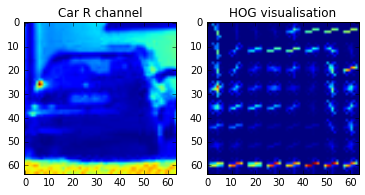

In [41]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

img = car_image[:,:,1]

features, hog_image = hog(img, orientations=orient, 
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False)
# visualise=True -> tells fn to output a viz of the HOG feature computation as well (RHS)
# feature_vector=True automatically unravels the features.

print("Features output shape", features.shape)

fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Car R channel')
plt.subplot(122)
plt.imshow(hog_image)
plt.title('HOG visualisation')

HOG visualisation is a repr that shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell, much like the "star" representation in the last video.

#### HOG pipeline

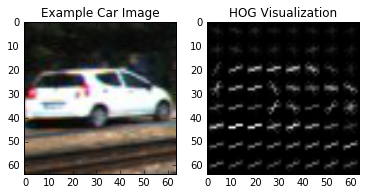

In [48]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Read in our vehicles and non-vehicles (done previously)
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis,
                                  feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

Thing I missed before: `transform_sqrt=True`. TODO: Still don't know what difference it makes.

![](images/21-14.png)


### Combining features
Combining colour-based and shape-based features.

Be careful of how you use features. E.g. using HSV with HOG. Easiest way to combine sets is to concatenate them.
![](images/21-15.png)
![](images/21-16.png)
![](images/21-17.png)
* Visualising vectors as bar plot, realise difference in magnitude. 
    * Normalisation step may prevent one type from dominating the other in later stages. 
* One feature set having many more elements than another may be a problem.
* Generally good to see if there are any redundancies in feature vectors
    * Drop ones that aren't contributing much using a decision tree.
![](images/21-18.png)


### Normalise data
Using `StandardScaler()` from `sklearn`. [Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
* Input: numpy array where each row is a single feature vector.
```
import numpy as np
feature_list = [feature_vec1, feature_vec2, ...]
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack(feature_list).astype(np.float64)
```
* Fit scaler to numpy array
```
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
```

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_color_features = bin_spatial(image, size=spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate([spatial_color_features, hist_features]))
    # Return list of feature vectors
    return features

images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

Key lines:
```
features.append(np.concatenate(spatial_color_features, hist_features))
```
Errors:
```
    features.append(np.concatenate(spatial_color_features, hist_features))
TypeError: only length-1 arrays can be converted to Python scalars
```
Debugged by:
```
print("Spatial color features: ", spatial_color_features)
print("Hist features: ", hist_features)
combined_features = np.concatenate(spatial_color_features, hist_features)
features.append(combined_features)
```

### Build a classifier to distinguish car and non-car images

#### Data and data preprocessing
* Needs lots of labelled data (patches of images that themselves are non-car and car images)
* Be wary of **class imbalance**. Generate additional data if needed.
    * Also within training and test sets.
* Split into training and test sets, where data is shuffled between and within each set.

![](images/21-19.jpg)
Training process:
![](images/21-20.jpg)

Error used to moderate the parameters. Once model has fallen below a certain threshold, can consider model sufficiently trained.

Beware of overfitting:


Type of classifier:
* SVMs have been shown to work well with HOG features.


Process:
* Define labels vector based on features lists (binary vector indicating whether each feature corresponds to a car or a non-car).
* Stack and scale our feature vectors (?)
* Shuffle and split the data into training and test sets.
* Define and train classifier


#### Color Classify
Play with the parameter values spatial and histbin in the exercise below to see how the classifier accuracy and training time vary with the feature vector input.

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


# Read in car and non-car images
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Results:
```
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
2.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9833
My SVC predicts:  [ 1.  0.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  0.  1.  0.  1.  1.]
0.00118 Seconds to predict 10 labels with SVC

Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 864
0.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9854
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  0.  1.  1.]
0.00109 Seconds to predict 10 labels with SVC
```
TODO: play with the values some more. L21.26


#### HOG Classify
Play with the parameters colorspace, orient, pix_per_cell, cell_per_block, and hog_channel to get a feel for what combination of parameters give the best results.

Note: `hog_channel` can take values of 0, 1, 2, or "ALL", meaning that you extract HOG features from the first, second, third, or all color channels respectively.

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Divide up into cars and notcars
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Results:

```

2.0 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.08 Seconds to train SVC...
Test Accuracy of SVC =  0.96
My SVC predicts:  [ 0.  0.  0.  1.  1.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  0.  1.  0.]
0.00108 Seconds to predict 10 labels with SVC



6.13 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
0.32 Seconds to train SVC...
Test Accuracy of SVC =  0.955
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
0.0012 Seconds to predict 10 labels with SVC

```

TODO: Play with these parameters some more. L21.27

### Sliding Windows Search

Step across an image in a grid pattern. Run classifier to give prediction for each step so it'll tell you which windows contain cars.

Write a function that takes in and image, start and stop positions in both x and y (imagine a bounding box for the entire search region), window size (x and y dimensions), and overlap fraction (also for both x and y). Your function should return a list of bounding boxes for the search windows, which will then be passed to draw draw_boxes() function.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None or x_start_stop[1] is None:
        x_start_stop=[0, img.shape[0]]
    if y_start_stop[0] is None or y_start_stop[1] is None:
        y_start_stop=[0, img.shape[1]]
    # Compute the span of the region to be searched
    span = [x_start_stop[1] - x_start_stop[0], 
            y_start_stop[1] - y_start_stop[0]]
    # Compute the number of pixels per step in x/y
    pixels_per_step = [xy_window[0] * (1 - xy_overlap[0]),
                       xy_window[1] * (1 - xy_overlap[1])]
    # Compute the number of windows in x/y
    number_of_windows = [int(span[0] // pixels_per_step[0] - 1),
                         int(span[1] // pixels_per_step[1] - 1)]
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for row in range(number_of_windows[1]):
        for column in range(number_of_windows[0]):            
            # Calculate each window position
            xstart = x_start_stop[0] + column * pixels_per_step[0]
            ystart = y_start_stop[0] + column * pixels_per_step[1]
            window_position = ((xstart, ystart), 
                               (xstart + pixels_per_step[0],
                                ystart + pixels_per_step[1]))
            # Append window position to list
            window_list.append(window_position)
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

Bugs:

1.
```
cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
SystemError: new style getargs format but argument is not a tuple
[[0.0, 0.0], [64.0, 64.0], [128.0, 128.0], [192.0, 192.0]
```
Changed line to
```
cv2.rectangle(imcopy, (bbox[0], bbox[1]), color, thick)```

2.

```
cv2.rectangle(imcopy, (bbox[0], bbox[1]), color, thick)
TypeError: integer argument expected, got float
Tuple:  0.0 0.0```


3. Previously didn't do the one minus

```
pixels_per_step = xy_window[0] * (1 - xy_overlap[0])
```


4. Window position: previously only did
```
(startx, starty)
```

Should be
```
window_list.append(((startx, starty), (endx, endy)))
```

#### Multi-scale windows
* Min and max scales and intermediate scales
* Restrict places you search


In [52]:
# lesson_functions.py
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


vehicles_smallset/cars1/1.jpeg
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.15 Seconds to train SVC...
Test Accuracy of SVC =  0.995


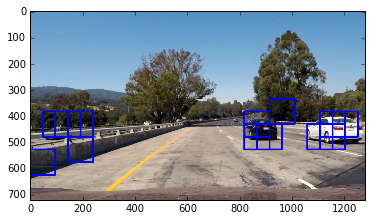

In [57]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_functions import *
from sklearn.model_selection import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('ve*.jpeg')
cars = glob.glob('vehicles_smallset/*/*.jpeg')
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')
"""
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""
print(cars[0])
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('../p5-vehicle-detection/test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

1. Original:
```
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.18 Seconds to train SVC...
Test Accuracy of SVC =  0.975
```
21-22.png

2. With `y_start_stop = [500,720]`

```
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.14 Seconds to train SVC...
Test Accuracy of SVC =  0.995
```
21-23.png
3. With HSV color space:
```
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.1 Seconds to train SVC...
Test Accuracy of SVC =  0.98
```

TODO: Play around with this more.

### Multiple Detections and False Positives

Aim is to have tight bounding boxes so you have correct position and size.
* Correcting duplicate detections
* Removing false positives
    * Else emergency braking when not necessary or may cause accidents.

Make a heat-map: 
* Add 'heat' (+=1) for all pixels within windows where a positive detection is reported by my classifier.
    * Do this for a list of bounding boxes (as opposed to per image frame) -> integrate a heat map over several frames of video.
* By imposing a threshold, you can reject areas affected by false positives. 
* Figure out how many cars you have in each frame and which pixels belong to which cars: 
```
from scipy.ndimage.measurements import label
labels = label(heatmap)
```

* `labels`:  a 2-tuple where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.
* threshold of n: set all values <=n to 0

```
heatmap = threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
```
21-26

Next, you can take your labels image and put bounding boxes around the labeled regions. You could do this in the following manner:

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread('img105.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)


In [ ]:
# Quiz code
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Read in a pickle file with bboxes saved
bbdict = pickle.load( open( "bbox_pickle.p", "rb" ))
# Extract "bboxes" field from bbdict
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
all_bboxes = bbdict["bboxes"]

# Read in the last image shown above 
image = mpimg.imread('img105.jpeg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


for idx, boxlist in enumerate(bboxes):
    
    
    

final_map = np.clip(heat - 2, 0, 255)
plt.imshow(final_map, cmap='hot')

### Tracking pipeline overview
* Search each frame using a sliding window technique.
* Record position of window where detections were made.
* Combine overlapping detections by taking the centroid of overlapping windows
    * Estimate where the centroid will appear to estimate where the car will go in subsequent frames
* Remove false positives using a thresholded heat map.

1. Decide what features to use (combination of colour and gradient features 
    * Experiment
2. Select and choose a classifier
    * Linear SVM probably best.
3. Implement a sliding window technique to search for vehicles in test images.
    * Minimise the number of search images. Experiment with different tiling schemes.
4. Reject false positives and combine overlapping detections.

### Tips and tricks for the project

#### 1. Extract HOG features just once for the entire region of interest in each full image / video frame
In one of the previous exercises you extracted HOG features from each individual window as you searched across the image, but it turns out this is rather inefficient. To speed things up, extract HOG features just once for the entire region of interest (i.e. lower half of each frame of video) and subsample that array for each sliding window. To do this, apply skimage.feature.hog() with the flag feature_vec=False, like this:
```
from skimage.feature import hog
orient = 9
pix_per_cell = 8
cell_per_block = 2

feature_array = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)

```
The output feature_array will have a shape of (n_xblocks, n_yblocks, 2, 2, 9), where n_xblocks and n_yblocks are determined by the shape of your region of interest (i.e. how many blocks fit across and down your image in x and y).

Then, depending on how many blocks you used to extract feature from the 64x64 pixel training images, you would simply extract that same number of blocks in x and y from feature_array and use np.ravel() to unroll the feature vector.

#### 2. Make sure your images are scaled correctly
The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, but cv2.imread() will scale them from 0 to 255. Be sure if you are switching between cv2.imread() and matplotlib image for reading images that you scale them appropriately! Otherwise your feature vectors can get screwed up.

To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 so if you are testing your pipeline on .jpg images remember to scale them accordingly. And if you take an image that is scaled from 0 to 1 and change color spaces using cv2.cvtColor() you'll get back an image scaled from 0 to 255. So just be sure to be consistent between your training data features and inference features!

#### 3. Be sure to normalize your training data
Use sklearn.preprocessing.StandardScaler() to normalize your feature vectors for training your classifier as described in this lesson. Then apply the same scaling to each of the feature vectors you extract from windows in your test images.